##I copied code

I tried doing it my own, tried gaussian edge detection but was unable to extract a person.
Below code is not mine, i have copied it from github repo:
[Github Link](https://github.com/danialkhilji/Lazy-Snapping-Image-Segmentation/tree/master) 

All i can do in this short time was to build an understanding of code.


In [2]:
import cv2
import numpy as np
import math
import timeit
from tqdm import tqdm
from google.colab.patches import cv2_imshow



coordinates functions is extracting all three channels of pictures and storing x,y values of all pixels whose 3rd channel has value 255.

In [3]:
def coordinates(seeds, p):
    (h, w) = seeds.shape[:2]
    n = 0
    for i in range(h):
        for j in range(w):
            if seeds[i][j][2] == p:
                n += 1
    x = [0]*n
    y = [0]*n
    v = 0
    for i in range(h):
        for j in range(w):
            if seeds[i][j][2] == p:
                x[v] = j
                y[v] = i
                v += 1
    return x, y

It performs a clustering algorithm where each pixel at coordinates (x[i], y[i]) recieved from coordinates function is assigned to the cluster with the closest RGB values among k clusters.

In [4]:
def clustering(k, x, y, c_red, c_green, c_blue, orig):
    clusters = np.array(x)
    for i in range(len(x)):
        a = [0.0] * k
        for j in range(k):
            r, g, b = orig[y[i]][x[i]]
            a[j] = float(math.sqrt(((r - c_red[j])**2) + ((g - c_green[j])**2) + ((b - c_blue[j])**2)))
            if j == (k - 1):
                clusters[i] = (np.argmin(a))
    return clusters


It implements the k-means clustering algorithm to assign pixels in an image (specified by x and y coordinates) to k clusters based on their RGB values. The algorithm iteratively updates the centroids and cluster assignments until convergence is reached.

In [5]:
def k_means(k, x, y,img_passed):
    img = img_passed
    a = len(x)/k
    print('length a:', a)
    c_red = [0] * k
    c_green = [0] * k
    c_blue = [0] * k
    v = 0
    for i in range(0, len(x), int(a)+1):
        #y_cord, x_cord = y[i], x[i]
        r, g, b = img[y[i]][x[i]]
        c_red[v] = r
        c_green[v] = g
        c_blue[v] = b
        v += 1
    clusters = clustering(k, x, y, c_red, c_green, c_blue, img)

    m, itr = 0, 0
    while m == 0:
        print('Iteration: ', itr)
        itr += 1
        w = np.zeros(k)
        updt_red = np.zeros(k)
        updt_green = np.zeros(k)
        updt_blue = np.zeros(k)
        for i in range(k):
            #v = 0
            for j in range(len(x)):
                if clusters[j] == i:
                    r, g, b = img[y[j]][x[j]]
                    updt_red[i] += r
                    updt_green[i] += g
                    updt_blue[i] += b
                    w[i] += 1
        for i in range(k):
            if w[i] != 0:
                updt_red[i] = updt_red[i] / w[i]
                updt_green[i] = updt_green[i] / w[i]
                updt_blue[i] = updt_blue[i] / w[i]
        for i in range(k):
            if abs(c_red[i] - updt_red[i]) > 2 or abs(c_green[i] - updt_green[i]) > 2 or abs(c_blue[i] - updt_blue[i]) > 2:
                clusters = clustering(k, x, y, updt_red, updt_green, updt_blue, img)
                c_red = updt_red
                c_green = updt_green
                c_blue = updt_blue
                break
            elif i == k-1:
                m = 1
    return clusters, updt_red, updt_green, updt_blue

This function calculates the weights of each cluster based on the cluster assignments stored in the clusters array. The weights represent the proportion of pixels assigned to each cluster relative to the total number of pixels in the clusters array.

In [6]:
def weight(k, clusters):
    wt = [0.0]*k
    for i in range(k):
        for j in range(len(clusters)):
            if clusters[j] == i:
                wt[i] += 1
            if j == len(clusters) - 1:
                wt[i] = float(wt[i] / len(clusters))
    return wt


It initializes foreground and background clusters and centroid values using the k-means algorithm. Then, it calculates the weights of the clusters and computes the likelihood of each pixel belonging to the foreground or background based on color similarity.

In [7]:
def main(img_passed,seeds_passed):
    start = timeit.default_timer()
    seeds = seeds_passed
    img = img_passed

    k = 64
    # Foreground
    print('Foreground')
    front_x, front_y = coordinates(seeds, 255)
    clusters_front, red_front, green_front, blue_front = k_means(k, front_x, front_y,img)
    # Background
    print('Background')
    back_x, back_y = coordinates(seeds, 6)
    clusters_back, red_back, green_back, blue_back = k_means(k, back_x, back_y,img)

    print('Weight Foreground')
    weight_front = weight(k, clusters_front)
    print('Weight Background')
    weight_back = weight(k, clusters_back)

    print('Likelihood')
    img_result = img.copy()
    (h, w) = img_result.shape[:2]
    for i in tqdm(range(h)):
        for j in range(w):
            #print(i, j)
            prob_back = 0
            prob_front = 0
            for m in range(k):
                r, g, b = img_result[i][j]
                prob_back += float(weight_back[m] * math.exp(-(math.sqrt(((r - red_back[m])**2) + ((g - green_back[m])**2)
                                                        + ((b - blue_back[m])**2)))))
                prob_front += float(weight_front[m] * math.exp(-(math.sqrt(((r - red_front[m])**2) + ((g - green_front[m])**2)
                                                       + ((b - blue_front[m])**2)))))
                if m == k - 1:
                    if prob_front > prob_back:
                        img_result[i][j][0] = 255
                        img_result[i][j][1] = 255
                        img_result[i][j][2] = 255
                    elif prob_front < prob_back:
                        img_result[i][j][0] = 0
                        img_result[i][j][1] = 0
                        img_result[i][j][2] = 0

    result = cv2.imread('/content/van Gogh.PNG')
    # Segmenting the original image
    print('Segmenting the original image')
    (h, w) = result.shape[:2]
    for i in tqdm(range(h)):
        for j in range(w):
            if img_result[i][j][0] == 0:
                result[i][j] = img_result[i][j]
    print("Segmentation")
    cv2_imshow(img_result)
    cv2.waitKey(0)
    print("Segmentation result")

    cv2_imshow(result)
    cv2.waitKey(0)

    end = timeit.default_timer()
    print("Run time", end - start)



Foreground
length a: 117.59375


<ipython-input-4-06aec160e236>:7: RuntimeWarning: overflow encountered in ubyte_scalars
  a[j] = float(math.sqrt(((r - c_red[j])**2) + ((g - c_green[j])**2) + ((b - c_blue[j])**2)))


Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Background
length a: 144.125
Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Iteration:  12
Weight Foreground
Weight Background
Likelihood


100%|██████████| 495/495 [05:07<00:00,  1.61it/s]


Segmenting the original image


100%|██████████| 495/495 [00:01<00:00, 430.61it/s]

Segmentation


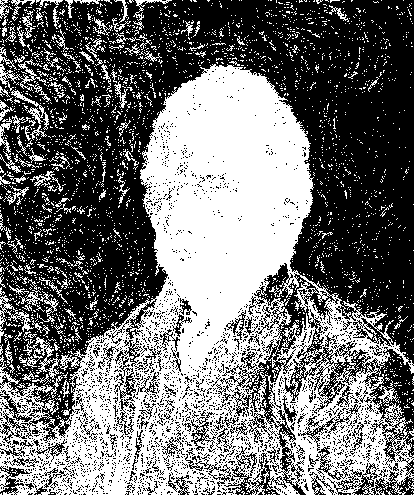

Segmentation result


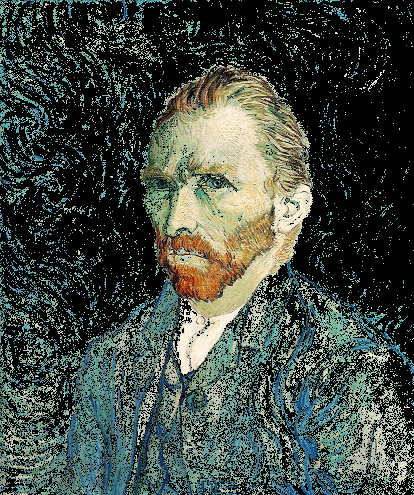

Run time 490.86034014100005


In [8]:
if __name__ == "__main__":
  img = cv2.imread('/content/van Gogh.PNG')
  seeds = cv2.imread('/content/van Gogh stroke.png')
  
  main(img,seeds)